In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset but only keep the top n words, zero the rest

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
# from matplotlib import pyplot as plt
# from dna2vec.multi_k_model import MultiKModel
# import seaborn as sns
# %matplotlib inline

In [4]:
#### Read fasta ####
def read_FASTA(file_name):
    with open(file_name, "r") as fn:
        text = fn.read().split(">")
    text = [x.split("\n") for x in text if x != ""]
    text = [[x[0],"".join(x[1:]).upper()] for x in text]
    text_dict = {line[0].split('|')[0]:line[1] for line in text}
    return text_dict

In [ ]:
# filepath = 'pretrained/dna2vec-20161219-0153-k3to8-100d-10c-29320Mbp-sliding-Xat.w2v'
# mk_model = MultiKModel(filepath)

In [ ]:
# len(mk_model.vector("AAATGGTT"))

# Data

In [5]:
code = read_FASTA("../../data/train_fasta_gencode.fasta")
noncode = read_FASTA("../../data/train_fasta_lncPedia.fasta")

# Preprocessing

## making data generator

In [6]:
def make_vec(seq, kmer=8, max_length=13000):
    vectors = []
    i = 0
    while (i<(len(seq)-kmer)) and (i<max_length):
        tmp = seq[i:i+kmer]
        if 'N' in tmp:
            i+=1
            continue
        vec_tmp = mk_model.vector(tmp)
        vectors.append(vec_tmp)
        i+=1
    return np.mean(vectors, axis=0)

In [7]:
from sklearn.cross_validation import train_test_split
from copy import deepcopy
from tqdm import tqdm

/home/cheskidova/py3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [97]:
N = 7000
y = np.array([1]*N + [0]*N)
X_tmp = deepcopy(list(code.items())[:N])
X_tmp.extend(list(noncode.items())[:N])
len(X_tmp)

14000

## making embedding matrix

In [19]:
embedding_matrix.to_csv("../../data/FINAL_DATA_1/embedding_matrix.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/FINAL_DATA_1/embedding_matrix.csv'

In [ ]:
k_mer = 8
embedding_matrix = dict()
"""
A -- 1
T -- 2
G -- 3
C -- 4

"""
for i1 in "ATGC":
    for i2 in "ATGC":
        for i3 in "ATGC":
            for i4 in "ATGC":
                for i5 in "ATGC":
                    for i6 in "ATGC":
                        for i7 in "ATGC":
                            for i8 in "ATGC":
                                name = i1+i2+i3+i4+i5+i6+i7+i8
                                embedding_matrix[name] = mk_model.vector(name)

embedding_matrix['0'] = np.zeros((100,))
embedding_matrix = pd.DataFrame(embedding_matrix).T
embedding_matrix.insert(0,'code', range(0, len(embedding_matrix)))
print(embedding_matrix.shape)
embedding_matrix.head()

In [20]:
embedding_matrix = pd.read_csv("../../data/embedding_matrix.csv", index_col=0)
embedding_matrix.head()

,code,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAAAAAAA,1,-0.365117,0.408025,0.064311,-0.293642,0.103023,0.089713,-0.764232,-0.003985,0.107479,...,-0.216967,-0.809641,0.370482,0.632726,0.690164,-0.406542,0.187238,-0.626230,-0.271666,0.082561
AAAAAAAC,2,-0.345430,0.288133,0.324433,-0.366527,-0.170981,-0.025718,-0.380066,0.055025,-0.016809,...,-0.233300,-0.737088,0.072006,0.639653,0.292097,-0.500181,0.094142,0.100279,-0.439565,0.160597
AAAAAAAG,3,0.000498,0.310706,-0.153957,-0.397525,0.163247,0.102393,-0.393191,-0.149867,0.093688,...,-0.132578,-0.596084,0.520723,0.664362,0.738464,-0.411244,-0.110038,-0.386498,-0.017523,-0.151797
AAAAAAAT,4,-0.276156,0.117486,0.097248,-0.301252,-0.194590,-0.149558,-0.705774,-0.121932,0.032583,...,0.003845,-0.890366,0.143492,0.220740,0.490493,0.093366,-0.143799,-0.783927,-0.192266,0.223240


In [21]:
encoder_dict = dict(zip(embedding_matrix.index, embedding_matrix.code))

In [98]:
def make_kmers(seq, kmer=8, max_length=7000):
    res = np.zeros((max_length))
    i=0
    while (i<(len(seq)-kmer)) and (i<max_length):
        tmp = seq[i:i+kmer]
        if 'N' in tmp:
            i+=1
            continue
        res[i] = encoder_dict[tmp]
        i+=1

    return res
X = np.array([np.array(make_kmers(v), dtype=np.int32) for k,v in X_tmp])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
embedding_matrix.index = embedding_matrix.code
embedding_matrix.drop('code', axis=1, inplace=True)

In [53]:
from keras.layers import Embedding
MAX_SEQUENCE_LENGTH = 7000
EMBEDDING_DIM = 100
embedding_layer = Embedding(len(embedding_matrix),
                            EMBEDDING_DIM,
                            weights=[np.array(embedding_matrix)],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [56]:
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.normalization import BatchNormalization

In [99]:
# y_train_dumm = np.array(pd.get_dummies(y_train))
# y_test_dumm = np.array(pd.get_dummies(y_test))

print("train: ", X_train.shape)
print("test: ", X_test.shape)

model = Sequential()
model.add(embedding_layer)
model.add(BatchNormalization())
model.add(Conv1D(filters=256, kernel_size=5, padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu'))
model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
model.add(GlobalAveragePooling1D())
# model.add(LSTM(128)) #,dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=10, batch_size=30, validation_data=(X_test, y_test)) #class_weight=Counter(y_train))

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

train:  (9380, 7000)
test:  (4620, 7000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 7000, 100)         6553700   
_________________________________________________________________
batch_normalization_12 (Batc (None, 7000, 100)         400       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 6996, 256)         128256    
_________________________________________________________________
batch_normalization_13 (Batc (None, 6996, 256)         1024      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 6992, 128)         163968    
_________________________________________________________________
batch_normalization_14 (Batc (None, 6992, 128)         512       
_________________________________________________________________
global_average_pooling1d_8 ( (None,

# specs test

In [59]:
test_fasta = read_FASTA("../../data/specs_4.0.fasta")

In [60]:
test = np.array([np.array(make_kmers(v), dtype=np.int32) for k,v in test_fasta.items()])

In [72]:
test_names = np.array([k for k,v in test_fasta.items()])

In [62]:
pred = model.predict(test)

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline

In [66]:
np.sum(pred>0.5)

66

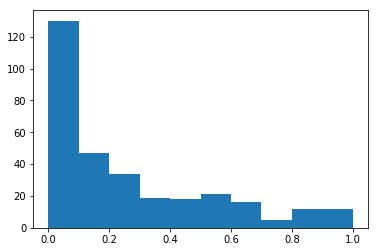

In [67]:
plt.hist(pred)
plt.show()

In [90]:
with open("../../data/pred_res.txt", 'w') as fs:
    for n, score in zip(test_names[pred>0.5], pred[pred>0.5]):
        fs.write(n+'\t'+str(score)+'\n')

In [ ]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

# Headline input: meant to receive sequences of 100 integers, between 1 and 10000.
# Note that we can name any layer by passing it a "name" argument.
main_input = Input(shape=(100,), dtype='int32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=512, input_dim=7000, input_length=100)(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

In [ ]:
model.save_weights('conv_model_weights.h5')

In [ ]:
import h5py